# Imports

In [1]:
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l2
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score, roc_auc_score
from numpy.random import seed
from keras.models import Sequential
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras import losses
from keras import optimizers
from keras import callbacks
import pandas as pd
import numpy as np
seed(1337)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Carregamento do dataset

In [2]:
%cd "../../Downloads"
df_train = pd.read_pickle("./train.pkl")
df_test = pd.read_pickle("./test.pkl")
df_train.head()

c:\Users\Gabriel\Downloads


conn_start_time  \
Scenario Bot  StartTime           SrcAddr                                     
3        Rbot 2011-08-12 15:24:00 147.32.84.164  2011-08-12 15:24:01.105402   
                                  207.200.96.138 2011-08-12 15:24:01.144027   
                                  147.32.84.170  2011-08-12 15:24:03.251544   
              2011-08-12 15:24:10 147.32.84.170  2011-08-12 15:24:13.252581   
              2011-08-12 15:24:15 147.32.84.170  2011-08-12 15:24:15.964800   

                                                  count   n_hosts  hosts_A  \
Scenario Bot  StartTime           SrcAddr                                    
3        Rbot 2011-08-12 15:24:00 147.32.84.164       1  0.000019        1   
                                  207.200.96.138      1  0.000019        0   
                                  147.32.84.170       3  0.000038        0   
              2011-08-12 15:24:10 147.32.84.170       3  0.000038        0   
              2011-08-12 15:24:15 147.32.84.170       3  0.000038        0   

                                                  hosts_B  hosts_C  hosts_N/A  \
Scenario Bot  StartTime           SrcAddr                                       
3        Rbot 2011-08-12 15:24:00 147.32.84.164         0        0          0   
                                  207.200.96.138        1        0          0   
                                  147.32.84.170         2        1          0   
              2011-08-12 15:24:10 147.32.84.170         2        1          0   
              2011-08-12 15:24:15 147.32.84.170         2        1          0   

                                                  hosts_public  hosts_private  \
Scenario Bot  StartTime           SrcAddr                                       
3        Rbot 2011-08-12 15:24:00 147.32.84.164              1              0   
                                  207.200.96.138             1              0   
                                  147.32.84.170              3              0   
              2011-08-12 15:24:10 147.32.84.170              3              0   
              2011-08-12 15:24:15 147.32.84.170              3              0   

                                                     dur_mean      dur_min  \
Scenario Bot  StartTime           SrcAddr                                    
3        Rbot 2011-08-12 15:24:00 147.32.84.164      6.650236     6.650236   
                                  207.200.96.138  3599.849609  3599.849609   
                                  147.32.84.170      0.006266     0.000396   
              2011-08-12 15:24:10 147.32.84.170      0.006375     0.000302   
              2011-08-12 15:24:15 147.32.84.170      0.096519     0.000270   

                                                      dur_max   dur_median  \
Scenario Bot  StartTime           SrcAddr                                    
3        Rbot 2011-08-12 15:24:00 147.32.84.164      6.650236     6.650236   
                                  207.200.96.138  3599.849609  3599.849609   
                                  147.32.84.170      0.017916     0.000486   
              2011-08-12 15:24:10 147.32.84.170      0.018322     0.000502   
              2011-08-12 15:24:15 147.32.84.170      0.288991     0.000297   

                                                   dur_std      dur_sum  \
Scenario Bot  StartTime           SrcAddr                                 
3        Rbot 2011-08-12 15:24:00 147.32.84.164   0.000000     6.650236   
                                  207.200.96.138  0.000000  3599.849609   
                                  147.32.84.170   0.010089     0.018798   
              2011-08-12 15:24:10 147.32.84.170   0.010347     0.019126   
              2011-08-12 15:24:15 147.32.84.170   0.166685     0.289558   

                                                  totpkts_mean  totpkts_min  \
Scenario Bot  StartTime           SrcAddr                                     
3        Rbot 2011-08-12 15:24:00 147.32.84.1

In [3]:
df_train.shape

(69409, 52)

In [4]:
df_test.shape

(45137, 52)

# Separação em X e Y, Scaling

In [4]:
# Training set 
Y_train = df_train['label'].reset_index(drop=True)
X_train = df_train.drop(['label'], axis=1).reset_index(drop=True)
X_train = X_train.drop('conn_start_time', axis=1)

X_train_normal = X_train[Y_train == 0]

# Testing set
Y_test = df_test['label'].reset_index(drop=True)
X_test = df_test.drop(['label'], axis=1).reset_index(drop=True)
X_test = X_test.drop('conn_start_time', axis=1)

X_test_normal = X_test[Y_test == 0]

scaler = StandardScaler().fit(X_train_normal)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train_normal = scaler.transform(X_train_normal)
X_test_normal = scaler.transform(X_test_normal)


# Variational Autoencoder

In [5]:
class Sampling(tf.keras.layers.Layer):
    """Sampling de z a partir de z_mean e z_log_var."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):
    """Implementação de Encoder com layers parametrizáveis"""

    def __init__(
        self,
        neurons,
        latent_dim,
        hidden_activation,
        name = "encoder",
        **kwargs
    ):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.neurons = neurons
        self.latent_dim = latent_dim
        self.hidden_layers = [Dense(neuron, activation=hidden_activation) for neuron in self.neurons]
        self.dense_mean = Dense(self.latent_dim)
        self.dense_log_var = Dense(self.latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.hidden_layers[0](inputs)
        for layer in self.hidden_layers[1:]:
            x = layer(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):
    """Implementação de Decoder com layers parametrizáveis"""

    def __init__(
      self,
      n_features,
      neurons,
      hidden_activation,
      output_activation,
      name = "decoder",
      **kwargs
    ):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.neurons = neurons
        self.n_features = n_features
        self.hidden_layers = [Dense(neuron, activation=hidden_activation) for neuron in self.neurons]
        self.dense_output = Dense(self.n_features, activation=output_activation)

    def call(self, inputs):
        x = self.hidden_layers[0](inputs)
        for layer in self.hidden_layers[1:]:
            x = layer(x)
        return self.dense_output(x)

class VAE(tf.keras.Model):
    """ Variational Autoencoder """

    def __init__(
        self,
        n_features,
        encoder_neurons,
        decoder_neurons,
        latent_dim,
        hidden_activation,
        output_activation,
        name = 'VAE',
        **kwargs
    ):
        super(VAE, self).__init__(name=name, **kwargs)
        self.n_features = n_features
        self.encoder_neurons = encoder_neurons
        self.decoder_neurons = decoder_neurons
        self.latent_dim = latent_dim
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.encoder = Encoder(
            latent_dim = self.latent_dim,
            neurons = self.encoder_neurons,
            hidden_activation = self.hidden_activation
        )
        self.decoder = Decoder(
            n_features = self.n_features,
            neurons = self.decoder_neurons,
            hidden_activation = self.hidden_activation,
            output_activation = self.output_activation
        )

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed


In [22]:
epochs = 1000
batch_size = 512
input_dim = 50
encoder_neurons = [512,512,1024]
latent_dim = 256
decoder_neurons = [1024,512,512]
hidden_activation = LeakyReLU(0.1)
output_activation = LeakyReLU(0.1)
learning_rate = 1e-4
decay = 1e-3

vae = VAE(
  n_features=input_dim,
  encoder_neurons=encoder_neurons,
  latent_dim=latent_dim,
  decoder_neurons=decoder_neurons,
  hidden_activation=hidden_activation,
  output_activation=output_activation
)

vae.compile(
  metrics=['accuracy'],
  loss='mse',
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)
  )

tb = TensorBoard(
  log_dir='./logs',
  histogram_freq=0,
  write_graph=True,
  write_images=True
  )

es = EarlyStopping(
  monitor='val_loss',
  patience=50,
  restore_best_weights=True
)


history = vae.fit(
  X_train_normal,
  X_train_normal,
  epochs=350,
  batch_size=batch_size,
  shuffle=True,
  validation_split=0.1,
  verbose=1,
  callbacks=[tb, es]
).history
train_x_predictions = vae.predict(X_train)
mse = tf.keras.losses.mse(train_x_predictions, X_train).numpy()
error_df = pd.DataFrame({'Reconstruction_error': mse,
                      'True_class': Y_train})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
for i in range (0, len(precision_rt[1:])):
  if precision_rt[1+i] == recall_rt[1+i]:
      threshold = threshold_rt[i]
test_x_predictions = vae.predict(X_test)
prediction_loss = tf.keras.losses.mse(test_x_predictions, X_test)
p = [0 if loss < threshold else 1 for loss in prediction_loss]
print(f1_score(Y_test, p))
print(roc_auc_score(Y_test, p))


Epoch 1/350
81/81 [==============================] - 3s 29ms/step - loss: 2.9153 - accuracy: 0.0417 - val_loss: 1.2358 - val_accuracy: 0.0273
Epoch 2/350
81/81 [==============================] - 2s 27ms/step - loss: 0.7509 - accuracy: 0.0543 - val_loss: 1.1393 - val_accuracy: 0.0548
Epoch 3/350
81/81 [==============================] - 3s 33ms/step - loss: 0.8238 - accuracy: 0.1276 - val_loss: 1.2001 - val_accuracy: 0.0476
Epoch 4/350
81/81 [==============================] - 3s 34ms/step - loss: 0.7329 - accuracy: 0.1033 - val_loss: 1.0766 - val_accuracy: 0.1174
Epoch 5/350
81/81 [==============================] - 3s 35ms/step - loss: 1.3938 - accuracy: 0.1465 - val_loss: 1.0947 - val_accuracy: 0.0895
Epoch 6/350
81/81 [==============================] - 3s 33ms/step - loss: 0.8102 - accuracy: 0.1100 - val_loss: 1.0714 - val_accuracy: 0.0570
Epoch 7/350
81/81 [==============================] - 3s 34ms/step - loss: 0.3415 - accuracy: 0.0881 - val_loss: 1.0380 - val_accuracy: 0.1013
Epoch 

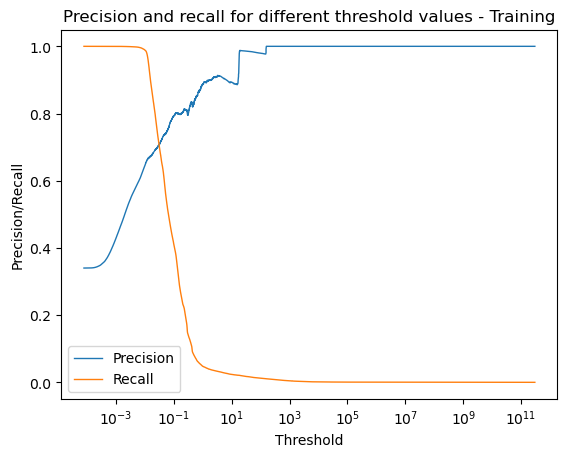

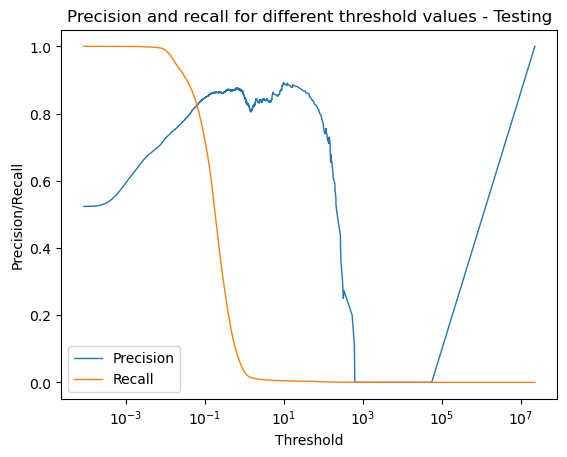

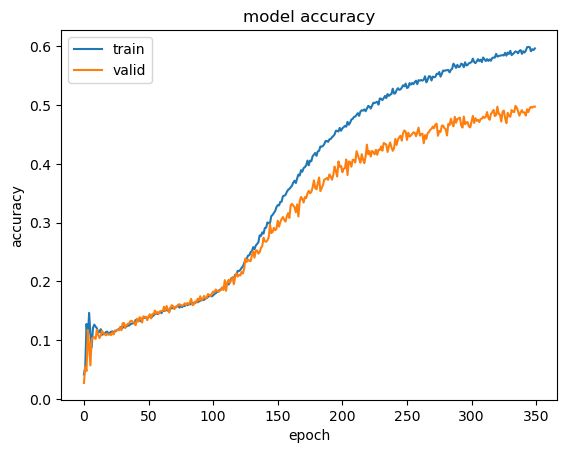

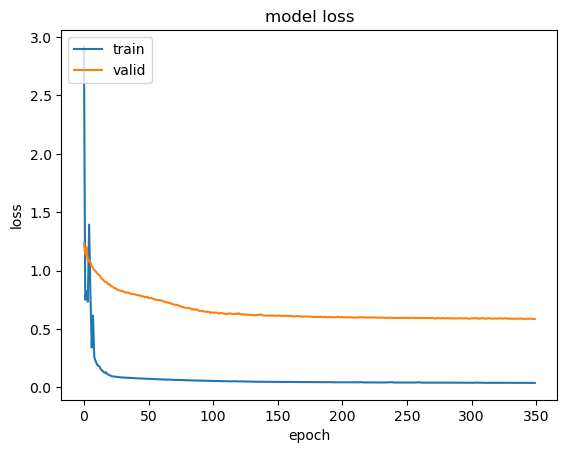

In [23]:
train_x_predictions = vae.predict(X_train)
mse = tf.keras.losses.mse(train_x_predictions, X_train).numpy()
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_train})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values - Training')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xscale('log')
plt.legend()
plt.show()
for i in range (0, len(precision_rt[1:])):
    if precision_rt[1+i] == recall_rt[1+i]:
        threshold = threshold_rt[i]
test_x_predictions = vae.predict(X_test)
mse = tf.keras.losses.mse(test_x_predictions, X_test).numpy()
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values - Testing')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xscale('log')
plt.legend()
plt.show()

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [24]:
# get the prediction on the test data
X_test_pred = vae.predict(X_test)  
prediction_loss = tf.keras.losses.mse(X_test_pred, X_test)

In [25]:
p = [0 if loss < threshold else 1 for loss in prediction_loss]

In [26]:
print(classification_report(Y_test,p))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79     21508
           1       0.78      0.91      0.84     23629

    accuracy                           0.82     45137
   macro avg       0.83      0.82      0.82     45137
weighted avg       0.83      0.82      0.82     45137



[[15797  5711]
 [ 2201 21428]]


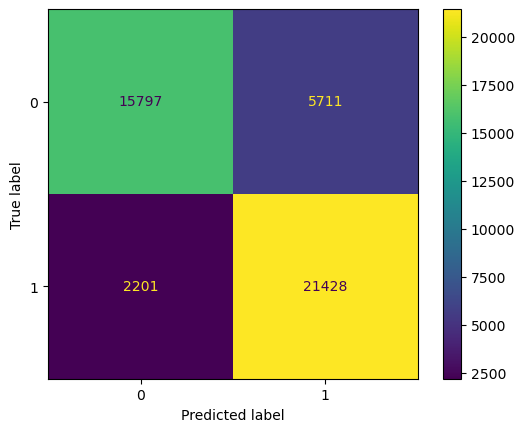

In [145]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, p, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Autoencoder

In [5]:
class Encoder(tf.keras.layers.Layer):
    """Implementação de Encoder com layers parametrizáveis"""

    def __init__(
      self,
      neurons,
      latent_dim,
      hidden_activation,
      name = "encoder",
      **kwargs
    ):
      super(Encoder, self).__init__(name=name, **kwargs)
      self.neurons = neurons
      self.latent_dim = latent_dim
      self.hidden_layers = [Dense(neuron, activation=hidden_activation) for neuron in self.neurons]
      self.dense_latent = Dense(self.latent_dim)

    def call(self, inputs):
      x = self.hidden_layers[0](inputs)
      for layer in self.hidden_layers[1:]:
        x = layer(x)
      return self.dense_latent(x)


class Decoder(tf.keras.layers.Layer):
    """Implementação de Decoder com layers parametrizáveis"""

    def __init__(
      self,
      n_features,
      neurons,
      hidden_activation,
      output_activation,
      name = "decoder",
      **kwargs
    ):
      super(Decoder, self).__init__(name=name, **kwargs)
      self.neurons = neurons
      self.n_features = n_features
      self.hidden_layers = [Dense(neuron, activation=hidden_activation) for neuron in self.neurons]
      self.dense_output = Dense(self.n_features, activation=output_activation)

    def call(self, inputs):
      x = self.hidden_layers[0](inputs)
      for layer in self.hidden_layers[1:]:
        x = layer(x)
      return self.dense_output(x)

class AE(tf.keras.Model):
  """ Autoencoder """

  def __init__(
    self,
    n_features,
    encoder_neurons,
    decoder_neurons,
    latent_dim,
    hidden_activation,
    output_activation,
    name = 'AE',
    **kwargs
  ):
    super(AE, self).__init__(name=name, **kwargs)
    self.n_features = n_features
    self.encoder_neurons = encoder_neurons
    self.decoder_neurons = decoder_neurons
    self.latent_dim = latent_dim
    self.hidden_activation = hidden_activation
    self.output_activation = output_activation
    self.encoder = Encoder(
      latent_dim = self.latent_dim,
      neurons = self.encoder_neurons,
      hidden_activation = self.hidden_activation
    )
    self.decoder = Decoder(
      n_features = self.n_features,
      neurons = self.decoder_neurons,
      hidden_activation = self.hidden_activation,
      output_activation = self.output_activation
    )

  def call(self, inputs):
    x = self.encoder(inputs)
    reconstructed = self.decoder(x)
    return reconstructed

In [134]:
epochs = 1000
batch_size = 512
input_dim = 50
encoder_neurons = [512,512,1024]
latent_dim = 100
decoder_neurons = [1024,512,512]
hidden_activation = LeakyReLU(0.5)
output_activation = LeakyReLU(0.5)
# hidden_activation = 'sigmoid'
# output_activation = 'sigmoid'
learning_rate = 1e-5
decay = 1e-5

autoencoder = AE(
    n_features=input_dim,
    encoder_neurons=encoder_neurons,
    latent_dim=latent_dim,
    decoder_neurons=decoder_neurons,
    hidden_activation=hidden_activation,
    output_activation=output_activation
)

autoencoder.compile(
    metrics=['accuracy'],
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)
  )

tb = TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    write_graph=True,
    write_images=True
  )

es = EarlyStopping(
  monitor='val_loss',
  patience=100,
  restore_best_weights=True
)

history = autoencoder.fit(
    X_train_normal,
    X_train_normal,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.1,
    verbose=1,
    callbacks=[tb, es]
  ).history


Epoch 1/1000
81/81 [==============================] - 2s 24ms/step - loss: 0.7635 - accuracy: 0.1166 - val_loss: 1.4106 - val_accuracy: 0.1170
Epoch 2/1000
81/81 [==============================] - 2s 22ms/step - loss: 0.6208 - accuracy: 0.0907 - val_loss: 1.1430 - val_accuracy: 0.0279
Epoch 3/1000
81/81 [==============================] - 2s 22ms/step - loss: 0.4734 - accuracy: 0.0313 - val_loss: 1.0341 - val_accuracy: 0.0373
Epoch 4/1000
81/81 [==============================] - 2s 22ms/step - loss: 0.3739 - accuracy: 0.1326 - val_loss: 0.9960 - val_accuracy: 0.1192
Epoch 5/1000
81/81 [==============================] - 2s 23ms/step - loss: 0.3044 - accuracy: 0.1447 - val_loss: 0.9774 - val_accuracy: 0.1312
Epoch 6/1000
81/81 [==============================] - 2s 22ms/step - loss: 0.2604 - accuracy: 0.1479 - val_loss: 0.9611 - val_accuracy: 0.1465
Epoch 7/1000
81/81 [==============================] - 2s 21ms/step - loss: 0.2310 - accuracy: 0.1427 - val_loss: 0.9465 - val_accuracy: 0.1443

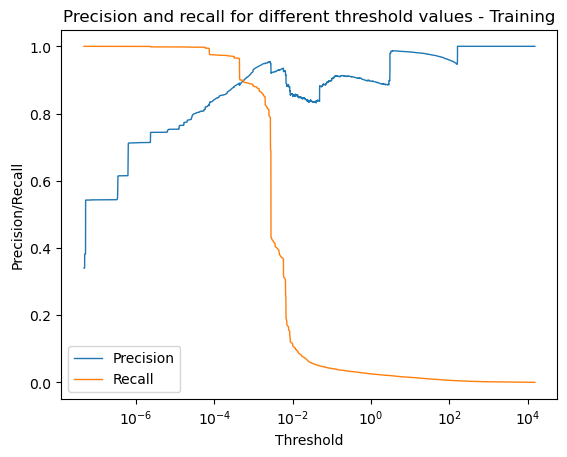

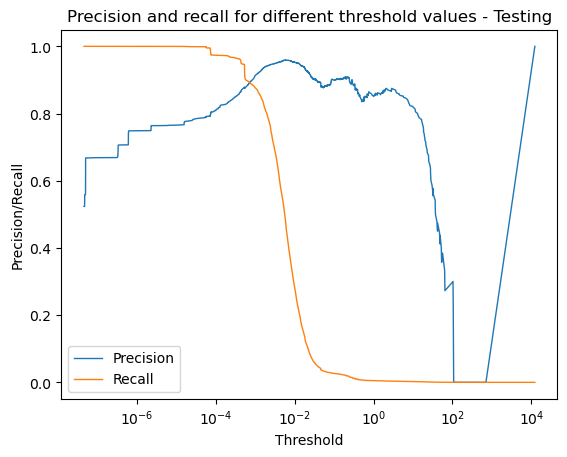

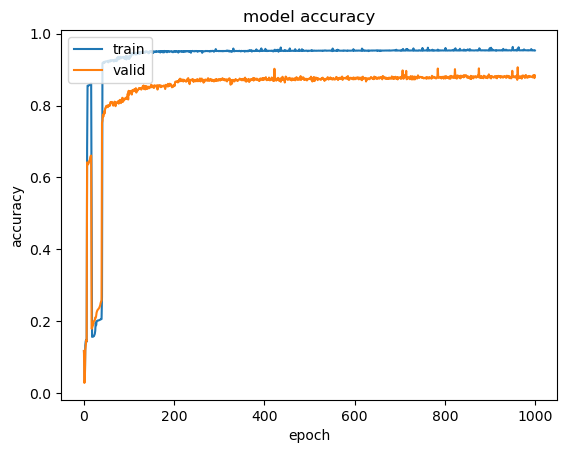

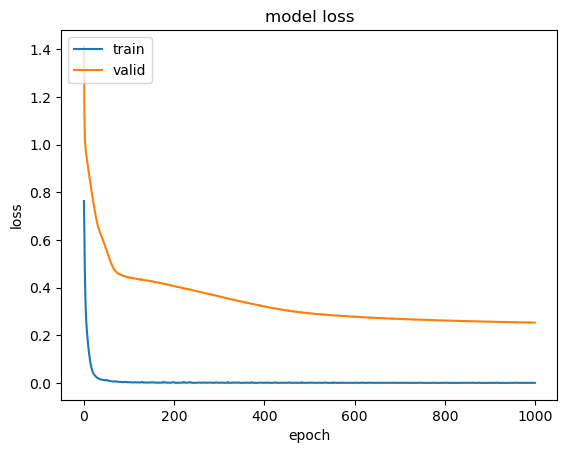

In [135]:
train_x_predictions = autoencoder.predict(X_train)
mse = tf.keras.losses.mse(train_x_predictions, X_train).numpy()
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_train})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values - Training')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xscale('log')
for i in range (0, len(precision_rt[1:])):
    if precision_rt[1+i] == recall_rt[1+i]:
        threshold = threshold_rt[i]
plt.legend()
plt.show()

test_x_predictions = autoencoder.predict(X_test)
mse = tf.keras.losses.mse(test_x_predictions, X_test).numpy()
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values - Testing')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xscale('log')
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [136]:
# get the prediction on the test data
X_test_pred = autoencoder.predict(X_test)  
prediction_loss = tf.keras.losses.mse(X_test_pred, X_test)

In [137]:
p = [0 if loss < threshold else 1 for loss in prediction_loss]

In [138]:
print(classification_report(Y_test,p))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     21508
           1       0.88      0.94      0.91     23629

    accuracy                           0.90     45137
   macro avg       0.91      0.90      0.90     45137
weighted avg       0.90      0.90      0.90     45137



[[15797  5711]
 [ 2201 21428]]


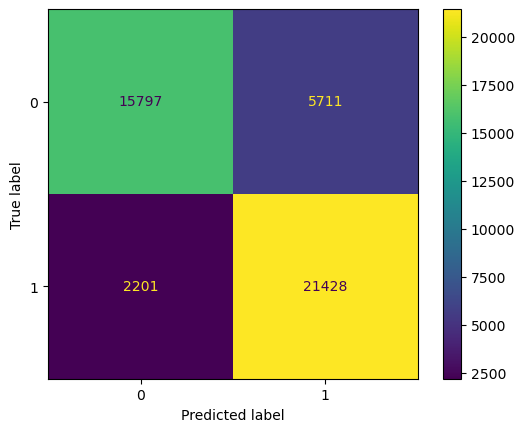

In [146]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, p, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Stacked Autoencoders

In [28]:
class Encoder(tf.keras.layers.Layer):
    """Implementação de Encoder com layers parametrizáveis"""

    def __init__(
      self,
      neurons,
      latent_dim,
      hidden_activation,
      name = "encoder",
      **kwargs
    ):
      super(Encoder, self).__init__(name=name, **kwargs)
      self.neurons = neurons
      self.latent_dim = latent_dim
      self.hidden_layers = [Dense(neuron, activation=hidden_activation) for neuron in self.neurons]
      self.dense_latent = Dense(self.latent_dim)

    def call(self, inputs):
      x = self.hidden_layers[0](inputs)
      for layer in self.hidden_layers[1:]:
        x = layer(x)
      return self.dense_latent(x)


class Decoder(tf.keras.layers.Layer):
    """Implementação de Decoder com layers parametrizáveis"""


    def __init__(
      self,
      n_features,
      neurons,
      hidden_activation,
      output_activation,
      name = "decoder",
      **kwargs
    ):
      super(Decoder, self).__init__(name=name, **kwargs)
      self.neurons = neurons
      self.n_features = n_features
      self.hidden_layers = [Dense(neuron, activation=hidden_activation) for neuron in self.neurons]
      self.dense_output = Dense(self.n_features, activation=output_activation)

    def call(self, inputs):
      x = self.hidden_layers[0](inputs)
      for layer in self.hidden_layers[1:]:
        x = layer(x)
      return self.dense_output(x)

class SAE(tf.keras.Model):
  """ Stacked Autoencoders """

  def __init__(
    self,
    n_features,
    encoder_neurons,
    decoder_neurons,
    latent_dim,
    hidden_activation,
    output_activation,
    n_stacks,
    name = 'SAE',
    **kwargs
  ):
    super(SAE, self).__init__(name=name, **kwargs)
    self.n_features = n_features
    self.encoder_neurons = encoder_neurons
    self.decoder_neurons = decoder_neurons
    self.latent_dim = latent_dim
    self.hidden_activation = hidden_activation
    self.output_activation = output_activation
    self.n_stacks = n_stacks
    self.encoder = Encoder(
      latent_dim = self.latent_dim,
      neurons = self.encoder_neurons,
      hidden_activation = self.hidden_activation
    )
    self.decoder = Decoder(
      n_features = self.n_features,
      neurons = self.decoder_neurons,
      hidden_activation = self.hidden_activation,
      output_activation = self.output_activation
    )

  def call(self, inputs):
    x = self.encoder(inputs)
    for _ in range(self.n_stacks - 1):
        x = self.decoder(x)
        x = self.encoder(x)
    reconstructed = self.decoder(x)
    return reconstructed

In [42]:
epochs = 1000
batch_size = 256
input_dim = 50
encoder_neurons = [512,512,1024]
latent_dim = 100
decoder_neurons = [1024,512,512]
n_stacks = 10
hidden_activation = LeakyReLU(0.5)
output_activation = LeakyReLU(0.5)
# hidden_activation = 'sigmoid'
# output_activation = 'sigmoid'
learning_rate = 1e-3
decay = 1e-3

sae = SAE(
  n_features=input_dim,
  encoder_neurons=encoder_neurons,
  latent_dim=latent_dim,
  decoder_neurons=decoder_neurons,
  hidden_activation=hidden_activation,
  output_activation=output_activation,
  n_stacks = n_stacks
)

sae.compile(
  metrics=['accuracy'],
  loss='mse',
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)
)

tb = TensorBoard(
  log_dir='./logs',
  histogram_freq=0,
  write_graph=True,
  write_images=True
)

es = EarlyStopping(
  monitor='val_loss',
  patience=50,
  restore_best_weights=True
)


history = sae.fit(
  X_train_normal,
  X_train_normal,
  epochs=epochs,
  batch_size=batch_size,
  shuffle=True,
  validation_split=0.1,
  verbose=1,
  callbacks=[tb, es]
).history


Epoch 1/1000
162/162 [==============================] - 18s 104ms/step - loss: 20068.8730 - accuracy: 0.0967 - val_loss: 1.6482 - val_accuracy: 0.0035
Epoch 2/1000
162/162 [==============================] - 16s 99ms/step - loss: 0.8419 - accuracy: 0.0031 - val_loss: 1.6168 - val_accuracy: 0.0031
Epoch 3/1000
162/162 [==============================] - 16s 99ms/step - loss: 0.8256 - accuracy: 0.0030 - val_loss: 1.6094 - val_accuracy: 0.0022
Epoch 4/1000
162/162 [==============================] - 16s 100ms/step - loss: 0.8215 - accuracy: 0.0028 - val_loss: 1.6075 - val_accuracy: 0.0022
Epoch 5/1000
162/162 [==============================] - 16s 100ms/step - loss: 0.8200 - accuracy: 0.0025 - val_loss: 1.6069 - val_accuracy: 0.0022
Epoch 6/1000
162/162 [==============================] - 17s 106ms/step - loss: 0.8193 - accuracy: 0.0024 - val_loss: 1.6067 - val_accuracy: 0.0017
Epoch 7/1000
162/162 [==============================] - 18s 109ms/step - loss: 0.8190 - accuracy: 0.0023 - val_loss:

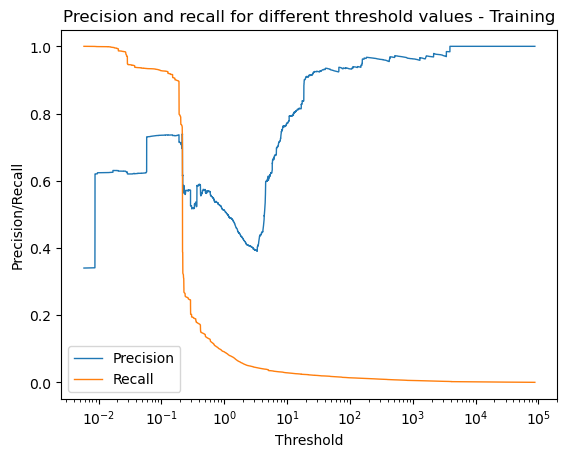

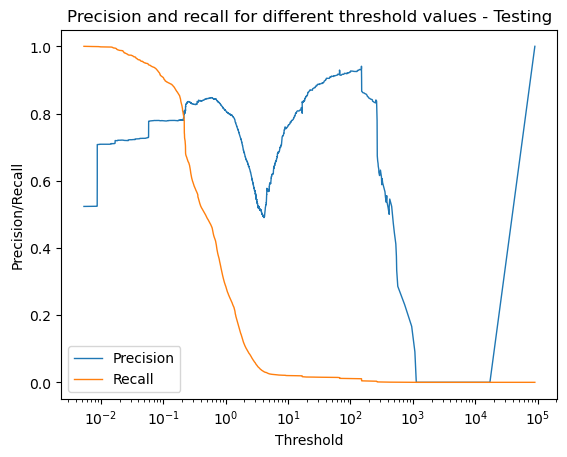

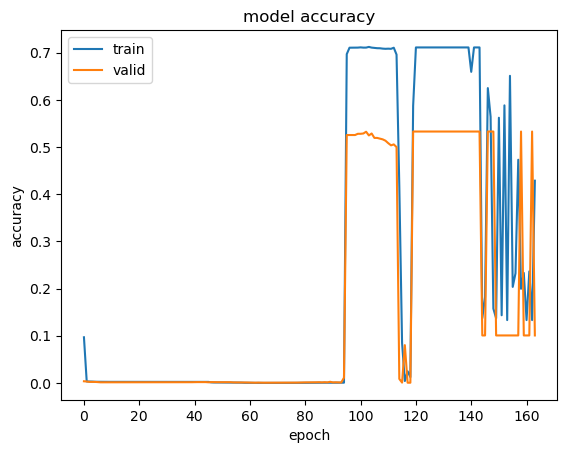

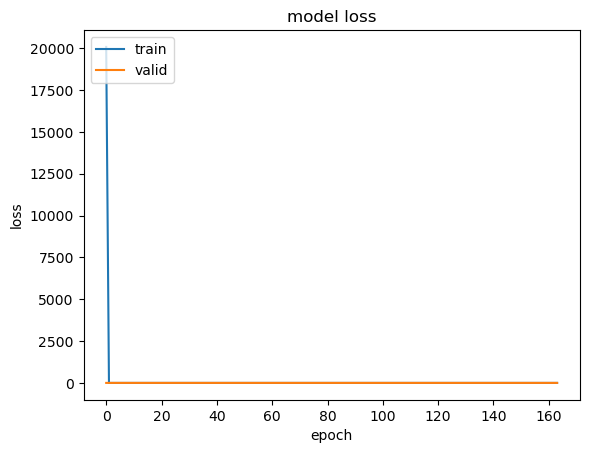

In [43]:
train_x_predictions = sae.predict(X_train)
mse = tf.keras.losses.mse(train_x_predictions, X_train).numpy()
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_train})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values - Training')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xscale('log')
plt.legend()
plt.show()
for i in range (0, len(precision_rt[1:])):
    if precision_rt[1+i] == recall_rt[1+i]:
        threshold = threshold_rt[i]

test_x_predictions = sae.predict(X_test)
mse = tf.keras.losses.mse(test_x_predictions, X_test).numpy()
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values - Testing')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xscale('log')
plt.legend()
plt.show()

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [44]:
# get the prediction on the test data
X_test_pred = sae.predict(X_test)  
prediction_loss = tf.keras.losses.mse(X_test_pred, X_test)

In [45]:
p = [0 if loss < threshold else 1 for loss in prediction_loss]

In [46]:
print(classification_report(Y_test,p))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     21508
           1       0.79      0.79      0.79     23629

    accuracy                           0.78     45137
   macro avg       0.78      0.78      0.78     45137
weighted avg       0.78      0.78      0.78     45137



[[16572  4936]
 [ 5025 18604]]


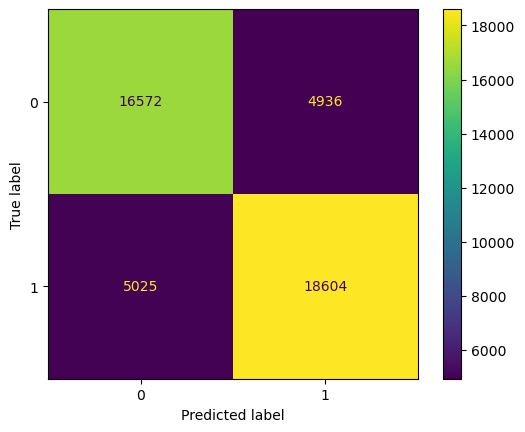

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, p, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500)

clf.fit(X_train, Y_train)

p = clf.predict(X_test)

print(classification_report(Y_test, p))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21508
           1       0.99      0.94      0.97     23629

    accuracy                           0.96     45137
   macro avg       0.96      0.97      0.96     45137
weighted avg       0.97      0.96      0.96     45137



[[21339   169]
 [ 1437 22192]]


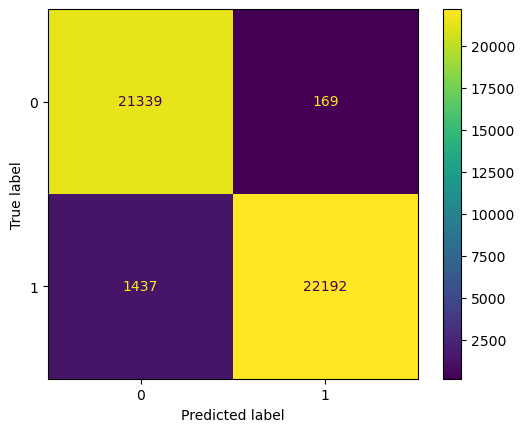

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, p, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)

clf.fit(X_train, Y_train)

p = clf.predict(X_test)

print(classification_report(Y_test, p))

C:\Users\Gabriel\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.85      0.97      0.91     21508
           1       0.97      0.85      0.90     23629

    accuracy                           0.91     45137
   macro avg       0.91      0.91      0.91     45137
weighted avg       0.91      0.91      0.91     45137



[[20892   616]
 [ 3615 20014]]


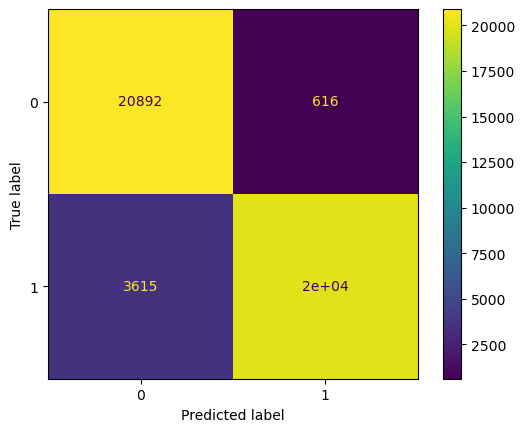

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, p, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()